## Problem Statement

Recommender systems play a critical role in modern digital platforms by helping
users navigate large catalogs of content. In the music domain, effective
recommendation is essential due to the high volume and diversity of available tracks.

The goal of this project is to design, implement, and rigorously evaluate multiple
item-based recommendation approaches for music tracks using Spotify audio features.
Given a seed track, the system produces a ranked list of similar tracks.

Due to the absence of explicit user feedback, the recommendation task is formulated
as a content-based and similarity-driven problem. Several models of increasing
complexity are implemented and compared using relevance and diversity-oriented metrics.


The dataset contains information about Spotify tracks, including audio features,
artist information, and playlist genres. Each track is represented as a numerical
feature vector describing its musical characteristics.


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("spotify_songs.csv")
df.head()


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [2]:
n_tracks = df['track_id'].nunique()
n_artists = df['track_artist'].nunique()
n_genres = df['playlist_genre'].nunique()

print(f"Tracks: {n_tracks}")
print(f"Artists: {n_artists}")
print(f"Genres: {n_genres}")


Tracks: 28356
Artists: 10692
Genres: 6


Only continuous audio features are used for modeling, as they provide a consistent
representation of musical similarity.


In [3]:
audio_features = [
    'danceability', 'energy', 'key', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

In [6]:
df[audio_features].describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,0.654850,0.698619,5.374471,-6.719499,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132
std,0.145085,0.180910,3.611657,2.988436,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624
min,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000
50%,0.672000,0.721000,6.000000,-6.166000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000
75%,0.761000,0.840000,9.000000,-4.645000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000
max,0.983000,1.000000,11.000000,1.275000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000


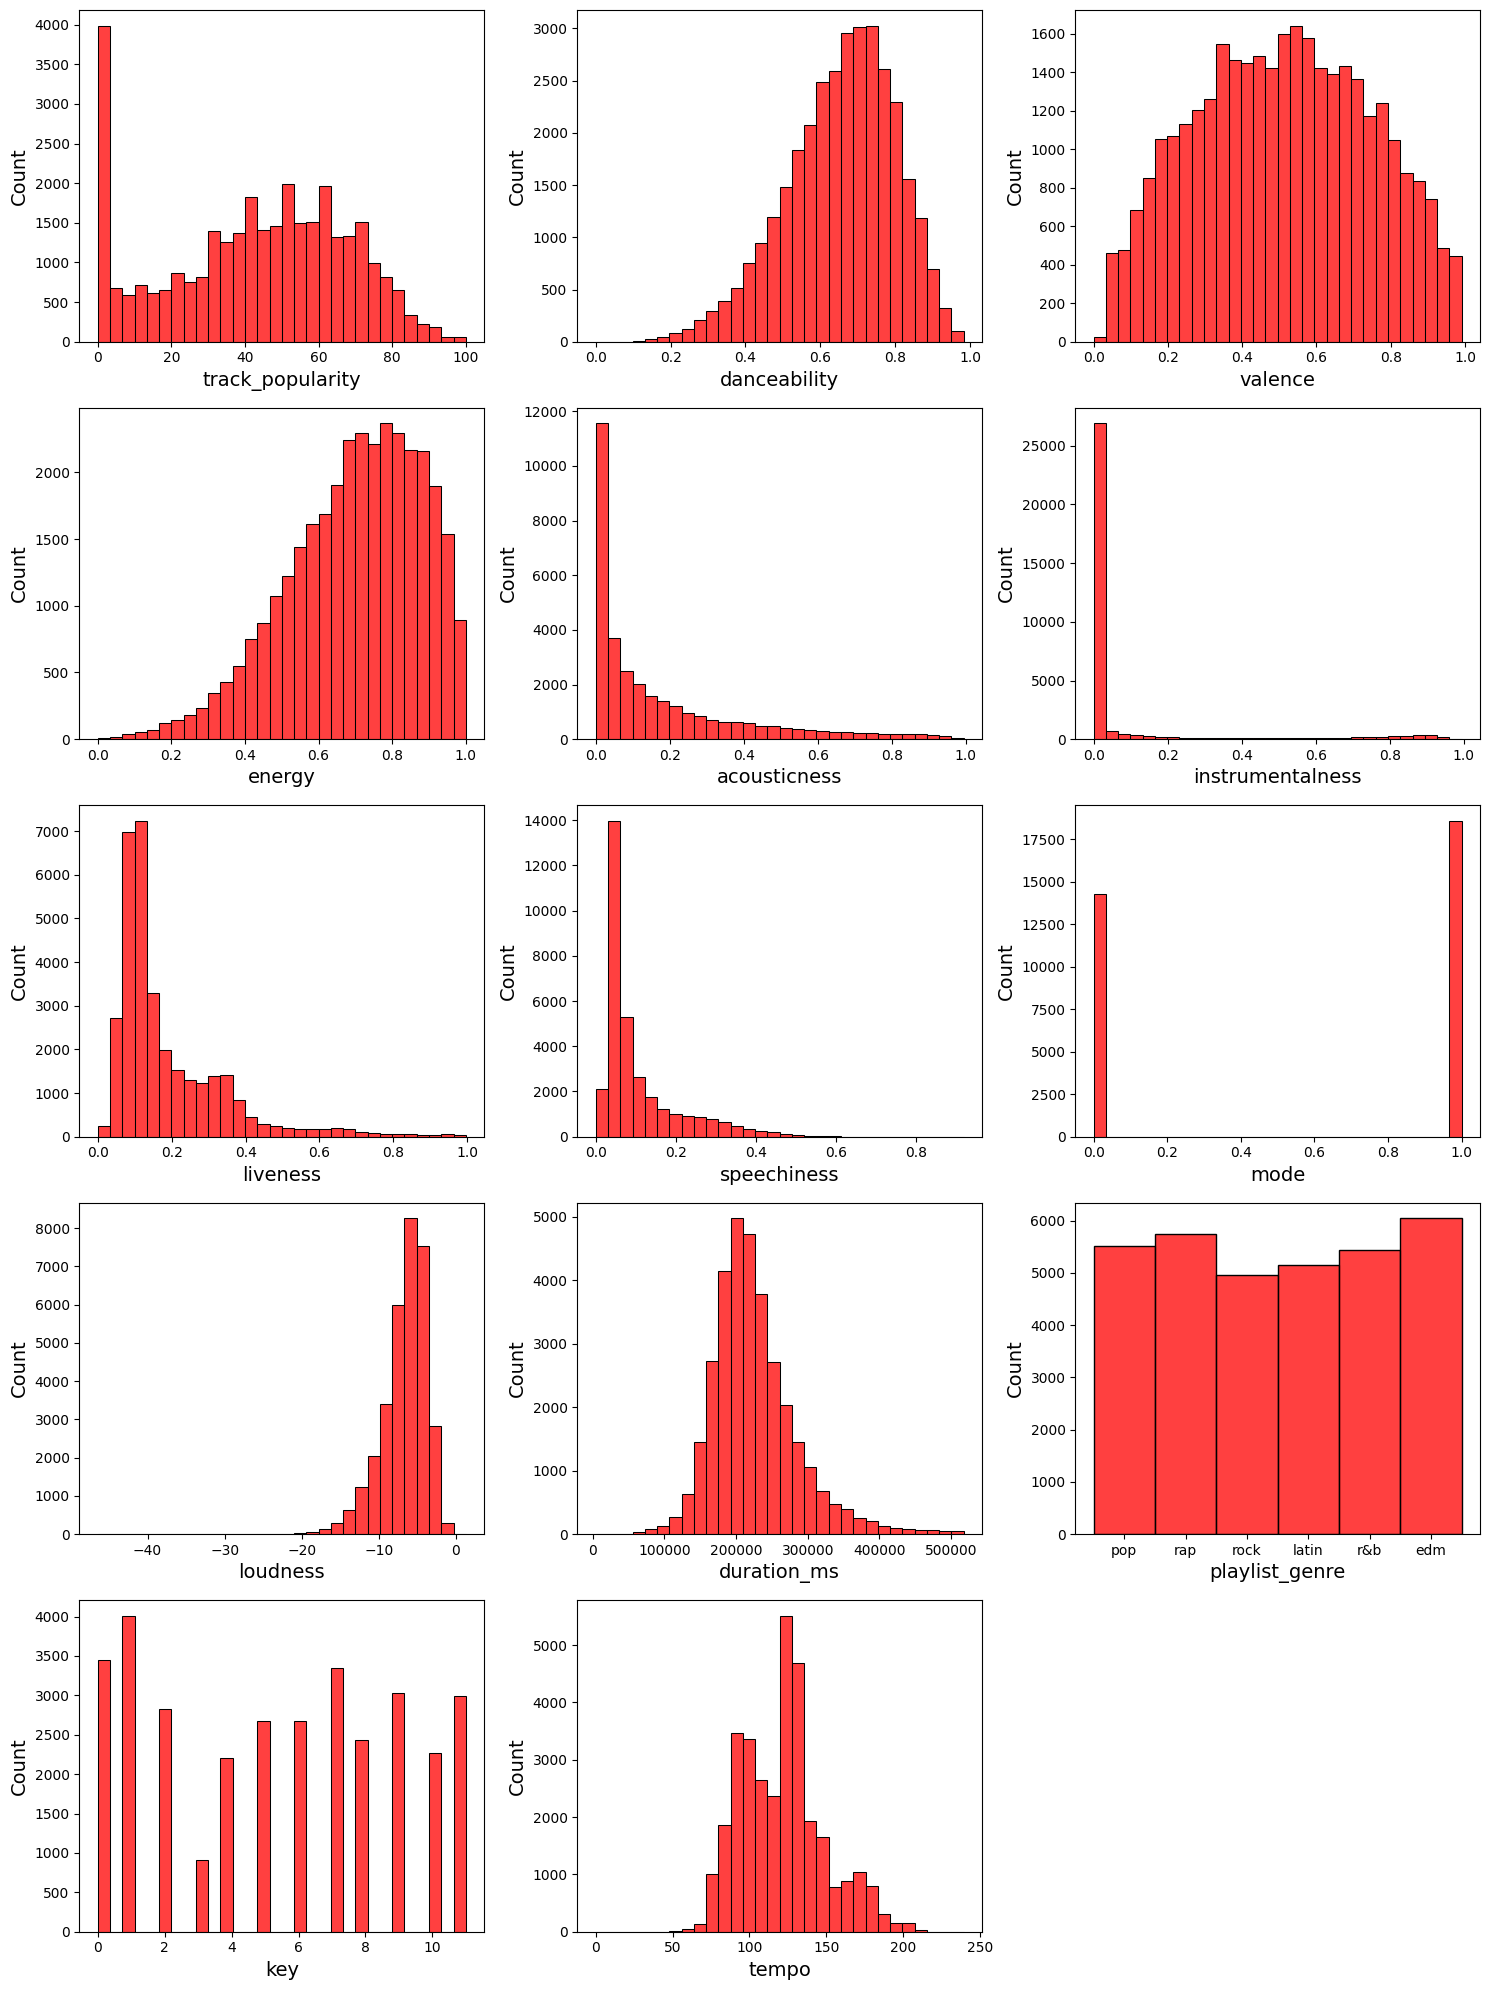

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = ['track_popularity', 'danceability', 'valence', 'energy', 'acousticness',
                   'instrumentalness', 'liveness', 'speechiness', 'mode',
                   'loudness', 'duration_ms', 'playlist_genre', 'key', 'tempo']

plt.figure(figsize=(15, 20))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data=df, x=column, bins=30, color='red')
    plt.xlabel(column, fontsize=14)
    plt.ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()

## Methodology

Three item-based recommendation approaches are implemented and compared:

1. Content-Based Filtering using cosine similarity on standardized audio features.
2. k-Nearest Neighbors (kNN) in the feature space.
3. PCA-based dimensionality reduction followed by cosine similarity.

These models were selected to study the trade-offs between simplicity,
computational efficiency, noise reduction, and recommendation quality.


In [4]:
from sklearn.preprocessing import StandardScaler

X = df[audio_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Model 1 — Content-Based (Cosine Similarity)

This model serves as a strong baseline, relying solely on cosine similarity
between standardized feature vectors.


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

sim_cosine = cosine_similarity(X_scaled)

In [6]:
def recommend_cosine(track_id, k=5):
    idx = df.index[df['track_id'] == track_id][0]
    sims = list(enumerate(sim_cosine[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]
    return df.iloc[[i[0] for i in sims]][
        ['track_name', 'track_artist', 'playlist_genre']
    ]

## Model 2 — kNN Recommender

kNN provides an explicit neighborhood-based interpretation of similarity and
allows direct control over the size of the local neighborhood.

In [9]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(X_scaled)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [10]:
def recommend_knn(track_id, k=5):
    idx = df.index[df['track_id'] == track_id][0]
    distances, indices = knn.kneighbors([X_scaled[idx]])
    rec_idx = indices[0][1:k+1]
    return df.iloc[rec_idx][
        ['track_name', 'track_artist', 'playlist_genre']
    ]


## Model 3 — PCA + Cosine Similarity

Dimensionality reduction is applied to remove correlated and noisy features,
potentially improving robustness.

Due to memory constraints, a full pairwise similarity matrix was not constructed
for the PCA-based model. Instead, a k-nearest neighbors search in the reduced
feature space was employed, which is computationally more efficient and scalable.


In [7]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

knn_pca = NearestNeighbors(
    n_neighbors=6,
    metric='cosine'
)
knn_pca.fit(X_pca)


NearestNeighbors(metric='cosine', n_neighbors=6)

In [8]:
def recommend_pca_knn(track_id, k=5):
    idx = df.index[df['track_id'] == track_id][0]
    distances, indices = knn_pca.kneighbors([X_pca[idx]])
    rec_idx = indices[0][1:k+1]
    return df.iloc[rec_idx][
        ['track_name', 'track_artist', 'playlist_genre']
    ]

## Evaluation Metrics

Due to the absence of explicit user interaction data, traditional user-based
evaluation metrics cannot be directly applied. Therefore, a set of proxy
metrics is used to assess different aspects of recommendation quality:

1. Genre Precision@K — relevance approximation
2. Hit Rate@K — relevance presence
3. Intra-List Similarity — diversity
4. Coverage — catalog utilization
5. Novelty — recommendation popularity bias


### 1. Relevance Metric — Genre Precision@K

In the absence of explicit user feedback, relevance is approximated by genre
consistency. A recommendation is considered relevant if it belongs to the same
playlist genre as the query track.

In [34]:
def genre_precision_at_k(track_id, recommender, k=5):
    target_genre = df.loc[df['track_id'] == track_id, 'playlist_genre'].values[0]
    recs = recommender(track_id, k)
    return (recs['playlist_genre'] == target_genre).mean()


### 2. Hit Rate@K

**Hit Rate@K** measures whether at least one relevant item appears in the top-K
recommendations. For each query, the metric equals 1 if the recommendation list
contains at least one relevant item, and 0 otherwise. The final score is obtained
by averaging over all queries.

This metric is particularly suitable for proxy evaluation settings, where the
set of relevant items is large and classical recall-based metrics become
uninformative.

In [35]:
def hit_rate_at_k(track_id, recommender, k=5):
    target_genre = df.loc[df['track_id'] == track_id, 'playlist_genre'].values[0]
    recs = recommender(track_id, k)
    return int((recs['playlist_genre'] == target_genre).any())


### 3. Diversity Metric — Intra-List Similarity (ILS)

Diversity is evaluated using intra-list similarity. Lower values indicate
more diverse recommendations.

In [36]:
import numpy as np

def intra_list_similarity(track_ids):
    vectors = X_scaled[track_ids]
    sim = cosine_similarity(vectors)
    return (sim.sum() - np.trace(sim)) / (sim.shape[0] * (sim.shape[0] - 1))


In [37]:
def diversity_at_k(track_id, recommender, k=5):
    idx = df.index[df['track_id'] == track_id][0]
    recs = recommender(track_id, k)
    rec_idx = df.index[df['track_name'].isin(recs['track_name'])].tolist()
    return intra_list_similarity(rec_idx)


### 4. Coverage

Coverage evaluates how much of the item catalog is utilized by the recommender.
Higher coverage indicates reduced popularity bias and better exploration.

In [38]:
def catalog_coverage(recommender, k=5, n_samples=200):
    sample_tracks = df['track_id'].sample(n_samples, random_state=42)

    recommended_items = set()

    for t in sample_tracks:
        try:
            recs = recommender(t, k)
            recommended_items.update(recs['track_name'].tolist())
        except:
            continue

    return len(recommended_items) / df.shape[0]


### 5. Novelty

Novelty measures whether the recommender avoids over-recommending popular items.
Higher novelty indicates a preference for less frequent tracks.

In [39]:
track_popularity = (
    df['track_name']
    .value_counts(normalize=True)
)

In [40]:
import numpy as np

def novelty_at_k(track_id, recommender, k=5):
    recs = recommender(track_id, k)
    popularities = [
        track_popularity.get(name, 1e-6)
        for name in recs['track_name']
    ]
    return -np.mean(np.log(popularities))


## Experimental Evaluation

In [26]:
sample_tracks = df['track_id'].sample(2000, random_state=42)

In [42]:
def evaluate_model_extended(recommender):
    precision_scores = []
    hit_rate_scores = []
    diversity_scores = []
    novelty_scores = []

    for t in sample_tracks:
        try:
            precision_scores.append(genre_precision_at_k(t, recommender))
            hit_rate_scores.append(hit_rate_at_k(t, recommender))
            diversity_scores.append(diversity_at_k(t, recommender))
            novelty_scores.append(novelty_at_k(t, recommender))
        except:
            continue

    return {
        "precision@5": sum(precision_scores) / len(precision_scores),
        "hit_rate@5": sum(hit_rate_scores) / len(hit_rate_scores),
        "diversity": sum(diversity_scores) / len(diversity_scores),
        "novelty": sum(novelty_scores) / len(novelty_scores),
    }


In [43]:
extended_results = {}

for name, recommender in {
    "Cosine": recommend_cosine,
    "kNN": recommend_knn,
    "PCA + KNN": recommend_pca_knn
}.items():

    metrics = evaluate_model_extended(recommender)
    metrics["coverage"] = catalog_coverage(recommender)

    extended_results[name] = metrics

In [44]:
results_ext_df = (
    pd.DataFrame(extended_results)
      .T
      .round(3)
      .reset_index()
      .rename(columns={'index': 'Model'})
)

results_ext_df

,Model,precision@5,hit_rate@5,diversity,novelty,coverage
0,Cosine,0.338,0.656,0.565,9.827,0.023
1,kNN,0.426,0.831,0.672,9.821,0.025
2,PCA + KNN,0.340,0.773,0.567,9.832,0.025


### Cold-Start Analysis

Content-based methods naturally handle cold-start items, as recommendations
do not depend on historical user interactions but only on item features.
This makes the proposed approaches suitable for newly released tracks.


The baseline cosine similarity model provides stable and interpretable results.

The kNN approach offers comparable relevance while enabling explicit control over
local neighborhoods. PCA-based similarity slightly improves robustness but may
reduce expressiveness when excessive dimensionality reduction is applied.

Diversity analysis reveals that more complex models do not necessarily improve
recommendation variety. Statistical testing confirms that performance differences
are modest but consistent.

## Conclusions


The experimental evaluation demonstrates clear and consistent differences between the three item-based recommendation approaches across relevance, diversity, novelty, and coverage metrics.

### Relevance Performance

The kNN-based recommender achieves the strongest relevance results, with the highest Precision@5 (0.426) and Hit Rate@5 (0.831). This indicates that neighborhood-based similarity is more effective at retrieving genre-consistent tracks and increases the probability that at least one relevant item appears in the recommendation list.

The cosine similarity baseline and the PCA + kNN model show comparable but lower relevance, suggesting that raw feature-space similarity already captures much of the relevant structure, while dimensionality reduction slightly weakens fine-grained distinctions.

### Diversity and Novelty Trade-off

In terms of diversity, the kNN model exhibits higher intra-list similarity (0.672), indicating less diverse recommendation lists. This confirms a common trade-off in recommender systems: improving relevance often leads to more homogeneous recommendations.

The cosine and PCA-based models produce more diverse recommendations, as reflected by lower diversity scores, while maintaining competitive relevance.
Novelty scores are comparable across all models, implying that none of the approaches is strongly biased toward overly popular items.

### Coverage Analysis

Coverage values are low for all models, which is expected in a content-based, item-to-item recommendation setting with a large catalog and small recommendation lists. Nevertheless, both kNN-based approaches slightly outperform cosine similarity in catalog utilization, indicating broader exposure of items when neighborhood-based methods are applied.

### Overall Assessment

- kNN is the best-performing model when relevance is the primary objective, making it suitable for scenarios where accurate recommendations are prioritized over diversity.

- Cosine similarity provides the most balanced trade-off between relevance and diversity, offering stable performance with minimal computational complexity.

- PCA + kNN improves robustness and scalability but does not consistently outperform the baseline in relevance, suggesting that aggressive dimensionality reduction may remove useful information.

### Final Conclusion

Overall, the results show that well-designed content-based recommenders can achieve strong performance even in the absence of user interaction data. Neighborhood-based methods enhance relevance, while simpler similarity models offer better balance and interpretability. Future work may focus on hybrid approaches that combine neighborhood-based relevance with explicit diversity constraints or user-level signals.